# NYC Taxi Duration Prediction
## 01. Initial Notebook

This notebook demonstrates a **simple notebook** for predicting NYC taxi trip durations.

**Workflow steps:**
1. Load data
2. Prepare features
3. Train model
4. Evaluate on validation set

## Imports
- **pandas**: Data manipulation
- **scikit-learn**: Feature engineering and linear regression
- **seaborn/matplotlib**: Visualization

In [1]:
import warnings
import time

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Feature engineering and linear regression
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Data Sources (Train/Validation)
The data used in this notebook comes from the [NYC Taxi & Limousine Commission Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

For this example **training data:** January 2024, and **validation data:** February 2024

In [2]:
TRAIN_PATH = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet'
VAL_PATH   = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet'

CATEGORICAL = ['PULocationID', 'DOLocationID']
TARGET = 'duration'

## Define Data Loading Function

We define a function to load and preprocess the raw taxi trip data. This ensures the data is clean and ready for modeling.

- `CATEGORICAL = ['PULocationID', 'DOLocationID']`: These columns represent the pickup and dropoff location IDs. We treat them as categorical variables because they are codes, not continuous values. This is important for feature engineering (e.g., one-hot encoding).

- The `read_data` function:
    - Reads a Parquet file from the given URL.
    - Calculates the trip duration in minutes by subtracting pickup from dropoff timestamps.
    - Filters out trips with unrealistic durations (keeps only trips between 1 and 60 minutes) to remove outliers and errors.
    - Converts the categorical columns to string type, which is required for correct one-hot encoding later.

This preprocessing step is essential to ensure the model receives clean, well-structured data and that categorical features are handled properly.

In [3]:
def read_data(path: str, categorical):
    df = pd.read_parquet(path)

    # Compute duration in minutes
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    # Filter outliers
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    # Treat IDs as categorical
    df[categorical] = df[categorical].astype(str)
    return df

## Load Train/Validation Data
We load both datasets using the same function to ensure identical preprocessing and reproducibility.

In [4]:
df_train = read_data(TRAIN_PATH, CATEGORICAL)
df_val   = read_data(VAL_PATH,   CATEGORICAL)
print('Train shape:', df_train.shape)
print('Val shape:  ', df_val.shape)
df_train.head()

Train shape: (2898906, 20)
Val shape:   (2938060, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,19.800000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6.600000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,17.916667
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,8.300000
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,6.100000


## Prepare Features (One‑Hot Encoding)

Most machine learning models can only work with numerical input. However, our location columns (`PULocationID` and `DOLocationID`) are categorical—they represent codes, not numbers with mathematical meaning.

To use these columns in our model, we convert them into a numerical format using **one-hot encoding**. This process creates a new binary column for each unique value, indicating its presence (1) or absence (0) in each row. We use scikit-learn's `DictVectorizer` to perform this transformation efficiently.

In [5]:
# Build dictionaries for the vectorizer
train_dicts = df_train[CATEGORICAL].to_dict(orient='records')
val_dicts   = df_val[CATEGORICAL].to_dict(orient='records')

# Fit on train, transform both
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val   = dv.transform(val_dicts)

y_train = df_train[TARGET].values
y_val   = df_val[TARGET].values

print('Feature matrix (train):', X_train.shape)
print('Number of features:    ', len(dv.feature_names_))

Feature matrix (train): (2898906, 518)
Number of features:     518


## Train Linear Regression
Fit a simple **Linear Regression** model on the one‑hot features, then compute **RMSE** (Root Mean Squared Error) on the training set.

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f'Train RMSE: {rmse_train:.3f}')

Train RMSE: 7.946


### Quick Visual Check

We will plot histograms of actual and predicted trip durations to visually compare their distributions. This helps us quickly see if the model's predictions match the real data pattern.

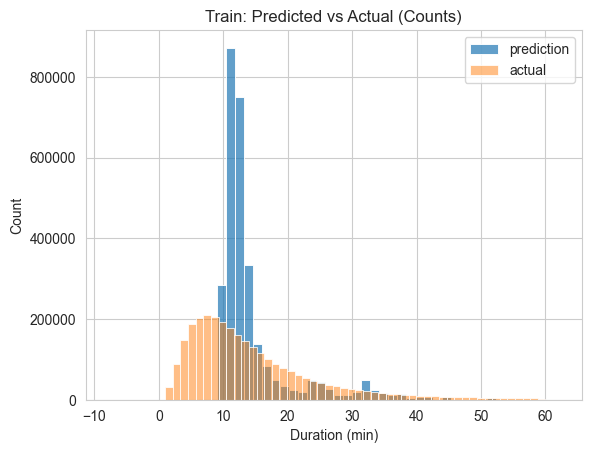

In [7]:
# Count-based histograms (same bins) for a clear overlay
bins = 50
sns.histplot(y_pred_train, label='prediction', stat='count', bins=bins, alpha=0.7)
sns.histplot(y_train,      label='actual',     stat='count', bins=bins, alpha=0.5)
plt.legend();
plt.xlabel('Duration (min)');
plt.ylabel('Count');
plt.title('Train: Predicted vs Actual (Counts)');
plt.show()

## Validate the Model
Use the **same vectorizer** on the validation set (never `fit` on validation), predict, and report RMSE.

In [8]:
y_pred_val = lr.predict(X_val)
rmse_val = root_mean_squared_error(y_val, y_pred_val)
print(f'Val RMSE: {rmse_val:.3f}')

Val RMSE: 8.123
